In [686]:
import config
from data_loader import *
import numpy as np
import pandas as pd
import networkx as nx
from joblib import delayed
from joblib import Parallel
from collections import Counter
from fast_pagerank import pagerank_power
import random
import igraph as ig
import matplotlib.pyplot as plt

from synthetic_networks.dpah import *

In [687]:
def remove_zero_degree(network, verbose=False):
    to_remove = [node for node, degree in dict(network.degree()).items() if degree < 1]
    network.remove_nodes_from(to_remove)

    if verbose:
        print(f"Removed {len(to_remove)} nodes with degree zero.")
    return to_remove

In [775]:
g82 = DPAH(N=20, 
             fm=0.3, 
             d=0.1,
             plo_M=2.5, 
             plo_m=2.5, 
             h_MM=0.8, 
             h_mm=0.2, 
             verbose=False)

In [776]:
g22 = DPAH(N=20, 
             fm=0.3, 
             d=0.1,
             plo_M=2.5, 
             plo_m=2.5, 
             h_MM=0.2, 
             h_mm=0.2, 
             verbose=False)

In [777]:
g28 = DPAH(N=20, 
             fm=0.3, 
             d=0.1,
             plo_M=2.5, 
             plo_m=2.5, 
             h_MM=0.2, 
             h_mm=0.99, 
             verbose=False)

In [778]:
g88 = DPAH(N=20, 
             fm=0.3, 
             d=0.1,
             plo_M=2.5, 
             plo_m=2.5, 
             h_MM=0.8, 
             h_mm=0.99, 
             verbose=False)

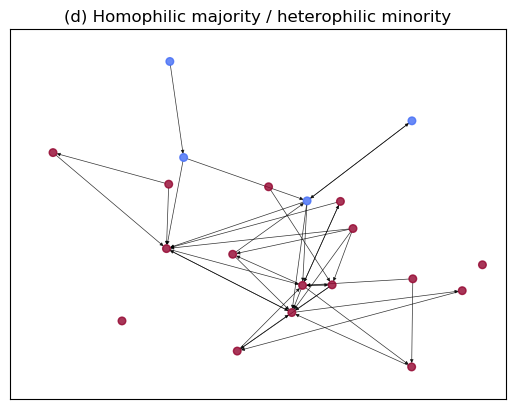

In [719]:
# z = remove_zero_degree(g88)
class_labels = nx.get_node_attributes(g88, 'm')
color_map = {1:'#446df6', 0: '#93032e'}
pos = nx.spring_layout(g88, iterations=10, scale=2)
# pos = nx.random_layout(g82)

nx.draw_networkx(
    G=g88,
    pos=pos,
    labels=class_labels,
    with_labels=False,
    alpha=0.8,
    node_size=30,
    arrowsize=5,
    width=0.5,
    node_color=[color_map[g88.nodes()[node]['m']] for node in g88],
)
plt.title("(d) Homophilic majority / heterophilic minority")
plt.show()

In [733]:
plt.clf()

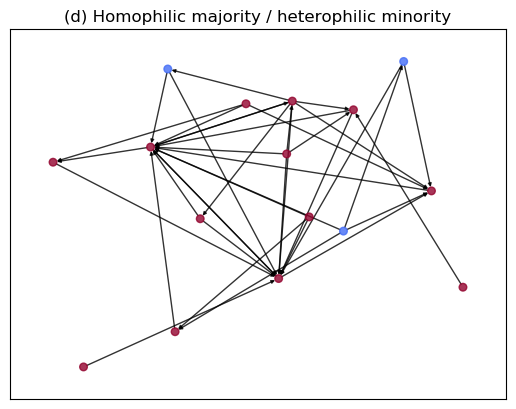

In [734]:
z = remove_zero_degree(g82)
class_labels = nx.get_node_attributes(g82, 'm')
color_map = {1:'#446df6', 0: '#93032e'}
pos = nx.spring_layout(g82, iterations=10, scale=2)
# pos = nx.random_layout(g82)

nx.draw_networkx(
    G=g82,
    pos=pos,
    labels=class_labels,
    with_labels=False,
    alpha=0.8,
    node_size=30,
    arrowsize=5,
    width=1,
    node_color=[color_map[g82.nodes()[node]['m']] for node in g82],
)
plt.title("(d) Homophilic majority / heterophilic minority")
plt.show()

In [739]:
gtest = DPAH(N=2, 
             fm=0.2, 
             d=0.1,
             plo_M=2.5, 
             plo_m=2.5, 
             h_MM=0.2, 
             h_mm=0.8, 
             verbose=False)

In [807]:
graphs = [g22, g28, g82, g88]
# titles = [ 
#     '(a) Heterophilic majority / heterophilic minority',
#     '(b) Heterophilic majority / homophilic minority',
#     '(c) Homophilic majority / heterophilic minority',
#     '(d) Homophilic majority / homophilic minority'
# ]

titles = [ 
    '(a) $h_M$ = 0.2 / $h_m$ = 0.2',
    '(b) $h_M$ = 0.2 / $h_m$ = 0.8',
    '(c) $h_M$ = 0.8 / $h_m$ = 0.2',
    '(d) $h_M$ = 0.8 / $h_m$ = 0.8'
]

In [816]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'35',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

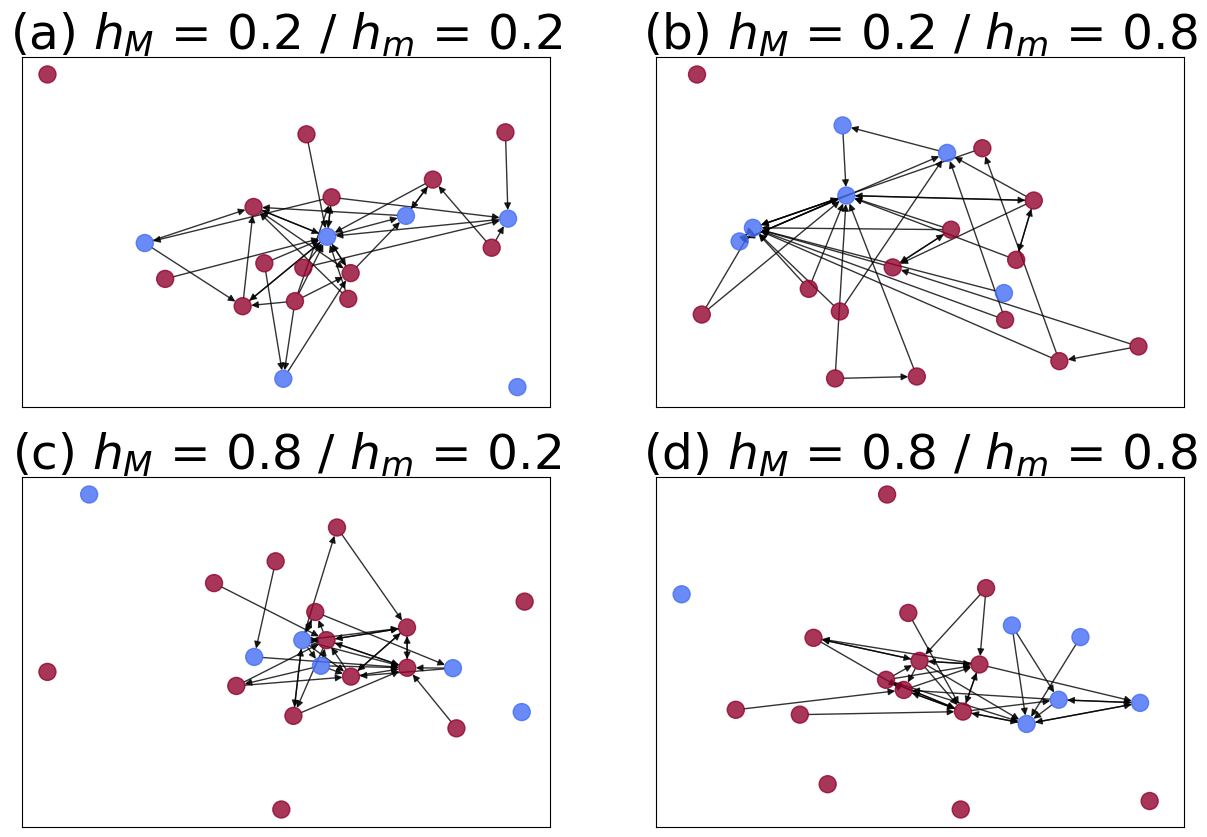

In [817]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
ax = axes.flatten()

for i in range(4):

    nx.draw_networkx(
        G=graphs[i],
        pos=nx.spring_layout(graphs[i], iterations=10, scale=2),
        labels=class_labels,
        with_labels=False,
        alpha=0.8,
        node_size=150,
        arrowsize=10,
        width=1,
        node_color=[color_map[graphs[i].nodes()[node]['m']] for node in graphs[i]],
        ax=ax[i]
    )

    ax[i].set_title(titles[i])

    # ax[i].set_axis_off()

plt.show()


In [2]:
BIGNET = 11000
EXT = '.gpickle'
TOPK = 10

In [465]:
def _ppr(node_index, A, p, top):
    pp = np.zeros(A.shape[0])
    pp[node_index] = A.shape[0]
    pr = pagerank_power(A, p=p, personalize=pp)
    pr = pr.argsort()[-top-1:][::-1]
    #time.sleep(0.01)
    return list(pr[pr!=node_index][:top])

def get_circle_of_trust_per_node(A, p=0.85, top=10, num_cores=40):
    return Parallel(n_jobs=num_cores)(delayed(_ppr)(node_index, A, p, top) for node_index in np.arange(A.shape[0]))

def frequency_by_circle_of_trust(A, cot_per_node=None, p=0.85, top=10, num_cores=40):
    results = cot_per_node if cot_per_node is not None else get_circle_of_trust_per_node(A, p, top, num_cores)
    unique_elements, counts_elements = np.unique(np.concatenate(results), return_counts=True)
    del(results)
    return [ 0 if node_index not in unique_elements else counts_elements[np.argwhere(unique_elements == node_index)[0, 0]] for node_index in np.arange(A.shape[0])]

def _salsa(node_index, cot, A, top=10):
    BG = nx.Graph()
    BG.add_nodes_from(['h{}'.format(vi) for vi in cot], bipartite=0)  # hubs
    edges = [('h{}'.format(vi), int(vj)) for vi in cot for vj in np.argwhere(A[vi,:] != 0 )[:,1]]
    BG.add_nodes_from(set([e[1] for e in edges]), bipartite=1)  # authorities
    BG.add_edges_from(edges)
    centrality = Counter({n: c for n, c in nx.eigenvector_centrality_numpy(BG).items() if type(n) == int
                                                                                       and n not in cot
                                                                                       and n != node_index
                                                                                       and n not in np.argwhere(A[node_index,:] != 0 )[:,1] })
    del(BG)
    #time.sleep(0.01)
    return np.asarray([n for n, pev in centrality.most_common(top)])[:top]

def frequency_by_who_to_follow(A, cot_per_node=None, p=0.85, top=10, num_cores=40):
    cot_per_node = cot_per_node if cot_per_node is not None else get_circle_of_trust_per_node(A, p, top, num_cores)
    results = Parallel(n_jobs=num_cores)(delayed(_salsa)(node_index, cot, A, top) for node_index, cot in enumerate(cot_per_node))
    unique_elements, counts_elements = np.unique(np.concatenate(results), return_counts=True)
    del(results)
    return [0 if node_index not in unique_elements else counts_elements[np.argwhere(unique_elements == node_index)[0, 0]] for node_index in np.arange(A.shape[0])]

def frequency_by_who_to_follow2(A, cot_per_node=None, p=0.85, top=10, num_cores=40):
    cot_per_node = cot_per_node if cot_per_node is not None else get_circle_of_trust_per_node(A, p, top, num_cores)
    results = Parallel(n_jobs=num_cores)(delayed(_salsa)(node_index, cot, A, top) for node_index, cot in enumerate(cot_per_node))
    unique_elements, counts_elements = np.unique(np.concatenate(results), return_counts=True)
    # del(results)
    return results

def who_to_follow_rank(A, njobs=-1, v1=False):
    if A.shape[0] < BIGNET:
        return wtf_small(A, njobs, v1=v1)
    else:
        # TODO: implement optimal (or faster) solution for big net
        return wtf_small(A, njobs)
        
def wtf_small(A, njobs, v1=False):
    # utils.printf('cot_per_node...')
    cot_per_node = get_circle_of_trust_per_node(A, p=0.85, top=TOPK, num_cores=njobs)

    # utils.printf('cot...')
    cot = frequency_by_circle_of_trust(A, cot_per_node=cot_per_node, p=0.85, top=TOPK, num_cores=njobs)
    if v1:
    # utils.printf('wtf...')
        wtf = frequency_by_who_to_follow(A, cot_per_node=cot_per_node, p=0.85, top=TOPK, num_cores=njobs)
    else:
        wtf = frequency_by_who_to_follow2(A, cot_per_node=cot_per_node, p=0.85, top=TOPK, num_cores=njobs)
    return wtf

In [5]:
def reindex_nodes(network, name_as_str=True):

    old = list(network.nodes())
    new = list(range(0, len(old)))

    if name_as_str:
        old_str = [str(i) for i in old]
        mapping1 = dict(zip(old, old_str))
    else:
        mapping1 = dict(zip(old, old))
    nx.set_node_attributes(network, values=mapping1, name='name')

    mapping2 = dict(zip(old, new))

    return nx.relabel_nodes(network, mapping2, copy=True)

In [113]:
def nx_to_ig(G):
    return ig.Graph.from_networkx(G)

In [12]:
gc = nx.connected_caveman_graph(l=5, k=100)

In [109]:
sample = random.sample(list(g.nodes()), 2000)

In [15]:
def get_circle_of_trust_per_node(A, p=0.85, top=10, num_cores=40):
    return [list(_ppr(node_index, A, p, top)) for node_index in np.arange(A.shape[0])]

In [261]:
g = read_pkl_graph("blogs_attributed_network_anon.gpickle")
g = reindex_nodes(g)

In [283]:
top_evc_nodes = get_topj_evc_nodes(network_obj=g, j=20, to_ig=True, mode='min')
top_bc_nodes = get_topj_bc_nodes(network_obj=g, j=20, to_ig=True, mode='min')

In [263]:
[data['m'] for node, data in g.nodes(data=True) if node in top_evc_nodes]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [264]:
[data['m'] for node, data in g.nodes(data=True) if node in top_bc_nodes]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [244]:
cot_per_node = get_circle_of_trust_per_node(A=nx.adjacency_matrix(g))

In [280]:
node_index = 1000
top = 10

In [281]:
g.nodes()[node_index]

{'m': 0, 'name': '1001'}

In [282]:
cot_test = cot_per_node[node_index]

In [603]:
def get_topj_bc_nodes(network_obj, j=5, to_ig=True, mode='min'):

    def nx_to_ig(G):
        return ig.Graph.from_networkx(G)

    if to_ig:
        g = nx_to_ig(network_obj)
    else:
        g = network_obj

    min_nodes_ig = g.vs.select(m=1)
    maj_nodes_ig = g.vs.select(m=0)

    bc_full = g.betweenness(directed=True)
    g.vs['bc'] = bc_full

    if mode == 'min':
        min_bc = min_nodes_ig.get_attribute_values('bc')
        # maj_bc = min_nodes_ig.get_attribute_values('bc')
        min_bc_temp = min_nodes_ig.get_attribute_values('bc')

        min_bc_temp.sort()
        topj = min_bc_temp[-j:]

        inds = [bc_full.index(t) for t in topj][-j:]

        return inds

    if mode == 'maj':
        maj_bc = maj_nodes_ig.get_attribute_values('bc')
        maj_bc_temp = maj_nodes_ig.get_attribute_values('bc')

        maj_bc_temp.sort()
        topj = maj_bc_temp[-j:]

        inds = [bc_full.index(t) for t in topj][-j:]

        return inds
    
    elif mode == 'both':
        min_bc = min_nodes_ig.get_attribute_values('bc')
        min_bc_temp = min_nodes_ig.get_attribute_values('bc')

        min_bc_temp.sort()
        topj = min_bc_temp[-j:]

        inds_min = [bc_full.index(t) for t in topj][-j:]

        maj_bc = maj_nodes_ig.get_attribute_values('bc')
        maj_bc_temp = maj_nodes_ig.get_attribute_values('bc')

        maj_bc_temp.sort()
        topj = maj_bc_temp[-j:]

        inds_maj = [bc_full.index(t) for t in topj][-j:]

        return inds_maj, inds_min


def get_topj_evc_nodes(network_obj, j=5, to_ig=True, mode='min'):

    def nx_to_ig(G):
        return ig.Graph.from_networkx(G)

    if to_ig:
        g = nx_to_ig(network_obj)
    else:
        g = network_obj

    min_nodes_ig = g.vs.select(m=1)
    maj_nodes_ig = g.vs.select(m=0)

    evc_full = g.eigenvector_centrality()
    g.vs['evc'] = evc_full

    if mode == 'min':
        min_evc = min_nodes_ig.get_attribute_values('evc')
        min_evc_temp = min_nodes_ig.get_attribute_values('evc')

        min_evc_temp.sort()
        topj = min_evc_temp[-j:]

        inds = [evc_full.index(t) for t in topj][-j:]

        return inds
    
    elif mode == 'maj':
        maj_evc = maj_nodes_ig.get_attribute_values('evc')
        maj_evc_temp = maj_nodes_ig.get_attribute_values('evc')

        maj_evc_temp.sort()
        topj = maj_evc_temp[-j:]

        inds = [evc_full.index(t) for t in topj][-j:]

        return inds

    elif mode == 'both':
        min_evc = min_nodes_ig.get_attribute_values('evc')
        min_evc_temp = min_nodes_ig.get_attribute_values('evc')

        min_evc_temp.sort()
        topj = min_evc_temp[-j:]

        inds_min = [evc_full.index(t) for t in topj][-j:]

        maj_evc = maj_nodes_ig.get_attribute_values('evc')
        maj_evc_temp = maj_nodes_ig.get_attribute_values('evc')

        maj_evc_temp.sort()
        topj = maj_evc_temp[-j:]

        inds_maj = [evc_full.index(t) for t in topj][-j:]

        return inds_maj, inds_min


def _ppr(node_index, A, p, top):
    pp = np.zeros(A.shape[0])
    pp[node_index] = A.shape[0]
    pr = pagerank_power(A, p=p, personalize=pp)
    pr = pr.argsort()[-top-1:][::-1]
    #time.sleep(0.01)
    return list(pr[pr!=node_index][:top])

def _get_circle_of_trust_per_node(A, p=0.85, top=10, num_cores=-1):
    return Parallel(n_jobs=num_cores)(delayed(_ppr)(node_index, A, p, top) for node_index in np.arange(A.shape[0]))

def _salsa_intervention(node_index, cot, A, top=10, to_add=[]):

    BG = nx.Graph()
    BG.add_nodes_from(['h{}'.format(vi) for vi in cot], bipartite=0)  # hubs
    edges = [('h{}'.format(vi), int(vj)) for vi in cot for vj in np.argwhere(A[vi,:] != 0 )[:,1]]
    BG.add_nodes_from(set([e[1] for e in edges]), bipartite=1)  # authorities
    BG.add_edges_from(edges)

    auths = [node for node, data in BG.nodes(data=True) if data['bipartite'] == 1]
    hubs = [int(node[1:]) for node, data in BG.nodes(data=True) if data['bipartite'] == 0]

    if g_re.nodes()[node_index]['m'] == 0:
       to_add = to_add[1]
    else:
       to_add = to_add[0]

    new_auths = [auth_node for auth_node in to_add if auth_node not in auths]
    new_auths_not_hubs = [n for n in new_auths if n not in hubs]

    intervention_edges = [(hub, new_auth) for hub in hubs for new_auth in new_auths_not_hubs]
    BG.add_nodes_from(new_auths_not_hubs, bipartite=1)
    BG.add_edges_from(intervention_edges)

    centrality = Counter({n: c for n, c in nx.eigenvector_centrality_numpy(BG).items() if type(n) == int
                                                                                        and n not in cot
                                                                                        and n != node_index
                                                                                        and n not in np.argwhere(A[node_index,:] != 0 )[:,1] })

    return np.asarray([n for n, pev in centrality.most_common(top)])[:top]

def get_intervention_recommendations(A, to_add=[], p=0.85, top=10, num_cores=-1):
    
    cot_per_node = _get_circle_of_trust_per_node(A, p, top, num_cores)
    results = Parallel(n_jobs=num_cores)(delayed(_salsa_intervention)(node_index, cot, A, top, to_add) for node_index, cot in enumerate(cot_per_node))
    # results = [_salsa_intervention(node_index, cot, A, top, to_add) for node_index, cot in enumerate(cot_per_node)]
    
    return results

In [619]:
g = nx.read_gpickle(config.ROOT + 'nx_DPAH_10000_0208_0802.pkl')
g_re = reindex_nodes(g)

In [604]:
g = read_pkl_graph("blogs_attributed_network_anon.gpickle")
g = reindex_nodes(g)

In [614]:
top_evc_maj, top_evc_min = get_topj_evc_nodes(network_obj=g, j=10, to_ig=True, mode='both')

In [615]:
[top_evc_maj, top_evc_min]

[[176, 223, 218, 83, 54, 221, 14, 112, 120, 117],
 [50, 107, 26, 5, 82, 11, 93, 10, 4, 2]]

In [579]:
# blogs all nodes with min maj switch
results = get_intervention_recommendations(A=nx.adjacency_matrix(g), to_add=[top_evc_maj, top_evc_min])

In [583]:
# blogs all nodes just 1
results = get_intervention_recommendations(A=nx.adjacency_matrix(g), to_add=top_evc_maj)

In [610]:
sample = random.sample(g.nodes(), 120)

In [611]:
A = nx.adjacency_matrix(g)

In [612]:
sample_cots = Parallel(n_jobs=-1)(delayed(_ppr)(node_index, A, 0.85, top) for node_index in sample)

In [613]:
d = dict(zip(sample, sample_cots))

In [616]:
results = Parallel(n_jobs=-1)(delayed(_salsa_intervention)(key, val, A, top, [top_evc_maj, top_evc_min]) for key, val in d.items())

In [628]:
node_index = 8000

In [621]:
g_re.nodes()[8000]

{'m': 1, 'name': '8952'}

In [630]:
cott = _ppr(node_index=node_index, A=nx.adjacency_matrix(g_re), p=0.85, top=TOPK)

In [631]:
cott

[609, 15, 7079, 387, 2046, 6396, 5537, 2067, 3568, 4677]

In [671]:
A = nx.adjacency_matrix(g_re)
# ix = get_topj_bc_nodes(network_obj=g, j=5, to_ig=True)

BG = nx.Graph()
BG.add_nodes_from(['h{}'.format(vi) for vi in cott], bipartite=0)  # hubs
edges = [('h{}'.format(vi), int(vj)) for vi in cott for vj in np.argwhere(A[vi,:] != 0 )[:,1]]
BG.add_nodes_from(set([e[1] for e in edges]), bipartite=1)  # authorities
BG.add_edges_from(edges)

centrality = Counter({n: c for n, c in nx.eigenvector_centrality_numpy(BG).items() if type(n) == int
                                                                                       and n not in cott
                                                                                       and n != node_index
                                                                                       and n not in np.argwhere(A[node_index,:] != 0 )[:,1] })

salsa_recomms = np.asarray([n for n, pev in centrality.most_common(top)])[:top]

In [672]:
auths = [node for node, data in BG.nodes(data=True) if data['bipartite'] == 1]
hubs = [node for node, data in BG.nodes(data=True) if data['bipartite'] == 0]

In [673]:
hubs_int = [int(hub[1:]) for hub in hubs]

In [674]:
hubs_int

[609, 15, 7079, 387, 2046, 6396, 5537, 2067, 3568, 4677]

In [675]:
top_evc = get_topj_evc_nodes(network_obj=g_re, j=10, to_ig=True, mode='maj')

In [676]:
new_auths = [auth_node for auth_node in top_evc if auth_node not in auths]

In [677]:
new_auths_not_hubs = [n for n in new_auths if n not in hubs_int]

In [678]:
new_auths_not_hubs

[346, 7209]

In [679]:
intervention_edges = [(hub, new_auth) for hub in hubs for new_auth in new_auths_not_hubs]

In [680]:
BG.add_nodes_from(new_auths_not_hubs, bipartite=1)
BG.add_edges_from(intervention_edges)

In [681]:
centrality = Counter({n: c for n, c in nx.eigenvector_centrality_numpy(BG).items() if type(n) == int
                                                                                       and n not in cott
                                                                                       and n != node_index
                                                                                       and n not in np.argwhere(A[node_index,:] != 0 )[:,1] })

salsa_recomms_intervention = np.asarray([n for n, pev in centrality.most_common(top)])[:top]

In [682]:
salsa_recomms_intervention

array([ 346, 7209, 1419, 1750, 3066, 5506, 5553, 7827, 6665,  132])

In [683]:
salsa_recomms

array([1419, 1750, 5553, 3066,  132, 7827, 6665, 2595, 5506,  719])

In [684]:
[data['m'] for node, data in g.nodes(data=True) if node in salsa_recomms_intervention]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [685]:
[data['m'] for node, data in g.nodes(data=True) if node in salsa_recomms]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [62]:
# a, b = nx.algorithms.bipartite.sets(BG)

In [44]:
a

{'h1', 'h10', 'h11', 'h12', 'h13', 'h14', 'h2', 'h4', 'h5', 'h7'}

In [19]:
node_id = 12

In [20]:
cot[node_id]

[2, 4, 10, 5, 93, 26, 11, 82, 107, 39]

In [23]:
r = _salsa2(node_index=node_id, cot=cot[node_id], ix=None, A=nx.adjacency_matrix(g), top=10)
r

array([ 90,  50,  92,  73, 211,  97, 117, 265,  24,  74])

In [24]:
r2 = _salsa2(node_index=node_id, cot=cot, ix=None, A=nx.adjacency_matrix(g), top=10)
r2

array([117,  50, 118, 197,  90,  52,  82, 221, 113, 393])

In [28]:
r3 = who_to_follow_rank(A=nx.adjacency_matrix(g))
r3[node_id]

array([ 90,  50,  92,  73, 211,  97, 117, 265,  24,  74])

In [128]:
ix = get_topj_min_bc_nodes(network_obj=g, j=5, to_ig=True)

In [129]:
ix

[876, 345, 1056, 575, 1958]

In [213]:
g = read_pkl_graph("blogs_attributed_network_anon.gpickle")

In [214]:
wtf_old = who_to_follow_rank(A=nx.adjacency_matrix(g), v1=True)

In [215]:
wtf_new = who_to_follow_rank(A=nx.adjacency_matrix(g), v1=False)

In [217]:
wtf_new

[array([ 45,  23,  26,  25, 102, 106,  31,  48,  41,  68]),
 array([107, 103, 102,  46,  49, 105,  89,  48,   5,  21]),
 array([ 73, 117, 101,  74,  52,  78, 243, 165, 196, 283]),
 array([ 11, 103, 102,  98,  31,  12,  21, 107,  92,  48]),
 array([ 50,  89, 105, 181,   8,  81,  95, 149,  39,  43]),
 array([ 26,  82,  92, 102,  13,  90,  98, 107,  11,  12]),
 array([  2,  10,   4, 107,  47,  93,  34, 264,  23, 102]),
 array([ 41,  12,  90,  89,  50,  46,  21, 149,  95, 181]),
 array([223, 221, 122, 349, 352, 302,  11,  10,  50, 113]),
 array([12, 41, 11, 23, 98, 31, 49, 13, 45,  7]),
 array([ 82,  26,  41,  49,  11,  90, 107,  12,  21, 102]),
 array([ 50,   8,  49,  90,  89,  21,  92,  26, 102, 103]),
 array([ 90,  50,  92,  73, 211,  97, 117, 265,  24,  74]),
 array([107, 103,  46,  49,  12,  50,  89, 105,  92, 149]),
 array([124, 120, 628, 309, 538, 221, 112,  96, 125, 804]),
 array([121, 124,  93, 221, 116, 744, 845, 517, 302, 533]),
 array([103, 107, 102,  89, 181,   7,  98, 106, 11

In [216]:
wtf_old

[110,
 25,
 217,
 1,
 214,
 91,
 0,
 71,
 71,
 0,
 299,
 314,
 292,
 74,
 53,
 0,
 0,
 1,
 0,
 0,
 0,
 226,
 6,
 96,
 21,
 132,
 241,
 0,
 0,
 0,
 0,
 75,
 0,
 4,
 177,
 0,
 0,
 0,
 0,
 34,
 2,
 233,
 0,
 28,
 0,
 81,
 169,
 173,
 130,
 255,
 137,
 0,
 6,
 0,
 20,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 7,
 7,
 1,
 4,
 0,
 5,
 50,
 1,
 31,
 205,
 17,
 0,
 17,
 0,
 0,
 7,
 139,
 232,
 0,
 163,
 219,
 53,
 31,
 44,
 9,
 119,
 1,
 27,
 12,
 303,
 264,
 111,
 91,
 50,
 455,
 18,
 4,
 16,
 18,
 49,
 157,
 20,
 122,
 82,
 42,
 32,
 19,
 203,
 102,
 10,
 2,
 74,
 54,
 12,
 0,
 3,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 37,
 3,
 0,
 0,
 0,
 4,
 1,
 30,
 3,
 0,
 0,
 20,
 4,
 0,
 0,
 0,
 0,
 16,
 0,
 0,
 14,
 0,
 20,
 3,
 16,
 16,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 23,
 8,
 0,
 0,
 0,
 71,
 118,
 26,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 113,
 145,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 3,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 37,
 8,
 0,
 

In [169]:
bba = nx.scale_free_graph(3000)

In [177]:
cave = nx.connected_caveman_graph(l=10, k=100)

In [145]:
network82 = nx.read_gpickle(config.ROOT + 'nx_DPAH_10000_0208_0802.pkl')

In [178]:
wtf = who_to_follow_rank(A=nx.adjacency_matrix(cave))

In [ ]:
recomm_dict = {}

for node in cave.nodes():
    r = twitter_wtf(network=cave, sparse_adj=nx.adjacency_matrix(cave), node_id=node, 
                    k_for_recommendation=-1, k_for_circle_of_trust=10)
    
    if len(r) > 0:
        recomm_dict[node] = r[0]
dists = [abs(tup[-1]-tup[0]) for tup in recomm_dict.values()]

In [179]:
pick = [random.choice(list(x)) if len(x) > 0 else 'skip' for x in wtf]

In [180]:
Counter(pick)['skip']

10

In [173]:
nodes = list(bba.nodes())

In [174]:
zz = dict(zip(nodes, pick))

In [175]:
dists = [abs(key-val) for key, val in zz.items()]

In [176]:
np.average(dists)

1372.541

In [94]:
cns = [len(list(nx.common_neighbors(cavemen, key, val))) for key, val in zz.items() if val in cavemen_nodes]

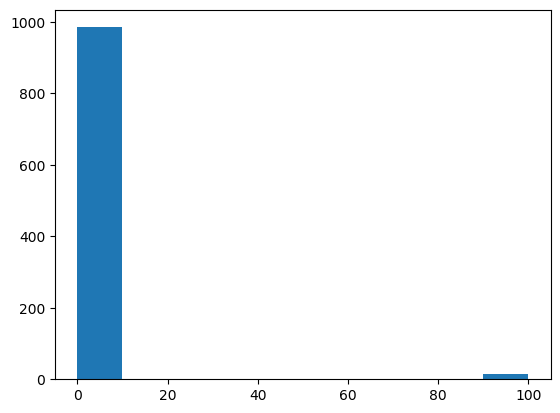

In [95]:
plt.hist(cns, bins=10)
plt.show()

In [206]:
g = read_pkl_graph("blogs_attributed_network_anon.gpickle")

In [188]:
sub_nodes = random.sample(list(g.nodes()), 500)

In [189]:
sub = nx.subgraph(g, sub_nodes)

In [195]:
disub = nx.DiGraph(sub)

In [205]:
pokec_sample = nx.read_gpickle(config.ROOT+'POKEC-A21/nx_pokec_sample_fabbri_netfile_relabeled_attributes.pkl')

In [230]:
sub_nodes = random.sample(list(pokec_sample.nodes()), 50000)
sub = nx.subgraph(pokec_sample, sub_nodes)
disub = nx.DiGraph(sub)

In [232]:
ls = [0, 1, 2, 3, 5, 6, 4]
ls[0:3]

[0, 1, 2]

In [231]:
print(disub.number_of_nodes())
print(disub.number_of_edges())

50000
85441


In [229]:
import seaborn as sns

In [222]:
def plot_degree_dist_per_group(G, attribute='', group_names=['', ''], group_labels=[1, 0]):
    minority = [G.degree(n[0]) for n in G.nodes(data=True) if n[-1][attribute] == group_labels[0]]
    majority = [G.degree(n[0]) for n in G.nodes(data=True) if n[-1][attribute] == group_labels[1]]
    
    fig, ax = plt.subplots(1, 2, sharey=True)
    fig.suptitle('Degree distribution by group')
    
    sns.histplot(ax=ax[0], data=minority)
    # ax[0].set_ylabel('test')
    ax[0].set_xlabel('Degree')
    ax[0].set_title(f'{group_names[0]} (minority)')

    sns.histplot(ax=ax[1], data=majority)
    ax[1].set_xlabel('Degree')
    ax[1].set_title(f'{group_names[1]} (majority)')

    plt.show()

In [ ]:
plot_degree_dist_per_group(disub, attribute='age', group_names=['young', 'old'], group_labels=['young', 'old'])

In [ ]:
wtf_pokec_50k = who_to_follow_rank(A=nx.adjacency_matrix(disub))

In [207]:
all_nodes = list(g.nodes())
k = random.sample(all_nodes, 100)

In [93]:
def twitter_wtf(network, sparse_adj, node_id, k_for_circle_of_trust=20, cot_factor= 0.05, tol=1e-8,
                damping_factor=.85, k_for_recommendation=-1):
    """This method aims to realize a link prediction algorithm used by Twitter to perform
        the WTF recommendation on the platform.
        The algorithm can be seen at 'https://web.stanford.edu/~rezab/papers/wtf_overview.pdf'.
        The algorithm consists of two phases:
            1) Compute the circle of trust for the user you want to recommend(top-k nodes in PPR)
            2) Compute the top-k nodes using score propagation
    """
    k_for_circle_of_trust = int(network.number_of_nodes()*cot_factor)
    # k_for_circle_of_trust = 30
    #1st phase: Compute circle of trust of user according to Personalized PageRank
    personalize = np.zeros(shape=network.number_of_nodes())
    personalize[node_id] = 1
    values_of_personalized_pr = pagerank_power(sparse_adj, p=damping_factor, personalize=personalize, tol=1e-6)
    circle_of_trust = values_of_personalized_pr.argsort()[-k_for_circle_of_trust:][::-1]

    #2nd phase: init bipartite graph
    bipartite_graph = nx.DiGraph()
    #add nodes belonging to the circle of trust as hubs(H)
    for node in circle_of_trust:
        #these nodes are "hubs"(H) in the bipartite graph
        bipartite_graph.add_node(str(node)+"H")
    #add out neighbors of nodes belonging to the circle of trust as authorities(A)
    for node in circle_of_trust:
        for out_neighbor in network.neighbors(node):
            #direction is inverted for a matter of simplicity in the sequent phases
            bipartite_graph.add_edge(str(out_neighbor)+"A", str(node)+"H")

    #retrieve adjacency matrix of bipartite graph
    A = nx.to_numpy_array(bipartite_graph)

    #retrieve list of all nodes splitted by authority or hub
    all_nodes = list(bipartite_graph.nodes())
    hub_nodes = [int(x[:-1]) for x in all_nodes if 'H' in x]
    authority_nodes = [int(x[:-1]) for x in all_nodes if 'A' in x]

    #3rd phase: start building ingredients of our SALSA algorithm
    #these are the transition matrices determined by the bipartite graph
    S_prime = A[len(hub_nodes):, :][:, :len(hub_nodes)].copy()
    R_prime = S_prime.T.copy()
    #normalize both matrices
    denominator_S_prime = S_prime.sum(axis=0)
    denominator_S_prime[denominator_S_prime == 0] = 1
    S_prime = S_prime / denominator_S_prime
    denominator_R_prime = R_prime.sum(axis=0)
    denominator_R_prime[denominator_R_prime == 0] = 1
    R_prime = R_prime / denominator_R_prime
    #these are the vectors which contain the score of similarity
    #and relevance
    s = np.zeros(shape=(len(hub_nodes), 1), dtype=np.float)
    r = np.zeros(shape=(len(authority_nodes), 1), dtype=np.float)

    #at the beginning of the procedure we put the similarity
    #of the user we want to give the recommendation equal to 1
    index_of_node_to_recommend = np.where(circle_of_trust == node_id)[0][0]
    s[index_of_node_to_recommend] = 1.

    #init damping vector
    alpha = 1 - damping_factor
    alpha_vector = np.zeros(shape=(len(hub_nodes), 1), dtype=np.float)
    alpha_vector[index_of_node_to_recommend] = alpha

    #4th phase: run the algorithm
    convergence = False
    while not convergence:
        s_ = s.copy()
        r_ = r.copy()
        r_ = S_prime.dot(s)
        s_ = alpha_vector + (1 - alpha)*(R_prime.dot(r))
        #compute difference and check if convergence has been reached
        diff = abs(s_ - s)
        if np.linalg.norm(diff) < tol:
            convergence=True
        #update real vectors
        s = s_
        r = r_

    #5th phase: order by score and delete neighbors of node to be recommended
    #of course we don't want to recommend people that the user already follow
    neighbors_to_not_recommend = nx.neighbors(network, node_id)
    relevance_scores = r.flatten()
    if k_for_recommendation == -1:
        k_for_recommendation = 0 #Take all the nodes!

    neighbors_to_not_recommend = set(neighbors_to_not_recommend)
    results = []
    for node in relevance_scores.argsort()[::-1]:
        if node not in neighbors_to_not_recommend and node != node_id:
            results.append(((node_id, node)))
            if len(results) == k_for_recommendation:
                break
    return results

In [181]:
r = twitter_wtf(test, nx.adjacency_matrix(test), 4, k_for_recommendation=-1)

In [184]:
l = []
l.append(r)

In [185]:
l

[[(4, 1),
  (4, 0),
  (4, 2),
  (4, 3),
  (4, 39),
  (4, 224),
  (4, 100),
  (4, 95),
  (4, 474),
  (4, 464),
  (4, 159),
  (4, 780),
  (4, 401),
  (4, 86),
  (4, 429),
  (4, 612),
  (4, 792),
  (4, 80),
  (4, 356),
  (4, 198),
  (4, 83),
  (4, 82),
  (4, 148),
  (4, 2652),
  (4, 1751),
  (4, 144),
  (4, 2291),
  (4, 81),
  (4, 2653),
  (4, 1418),
  (4, 1885),
  (4, 79),
  (4, 2498),
  (4, 255),
  (4, 345),
  (4, 216),
  (4, 71),
  (4, 1988),
  (4, 160),
  (4, 2651),
  (4, 2654),
  (4, 84),
  (4, 97),
  (4, 164),
  (4, 6),
  (4, 115),
  (4, 421),
  (4, 428),
  (4, 2628),
  (4, 25),
  (4, 29),
  (4, 138),
  (4, 59),
  (4, 1130),
  (4, 722),
  (4, 1498),
  (4, 326),
  (4, 2216),
  (4, 622),
  (4, 1239),
  (4, 38),
  (4, 370),
  (4, 1005),
  (4, 760),
  (4, 2215),
  (4, 2217),
  (4, 2218),
  (4, 467),
  (4, 641),
  (4, 65),
  (4, 794),
  (4, 945),
  (4, 167),
  (4, 68),
  (4, 134),
  (4, 930),
  (4, 599),
  (4, 425),
  (4, 774),
  (4, 135),
  (4, 577),
  (4, 103),
  (4, 946),
  (4, 591),


In [31]:
top_10pct = r[: int(len(r)*0.1)]

In [33]:
cls = [test.nodes()[edge[1]]['m'] for edge in top_10pct]

In [37]:
cls

[0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [38]:
x =  {'a': 0,
'b':0}

In [39]:
for i in range(5):

    if i % 2 == 0:
        x['a']+=1
    else:
        x['b']+=1

In [46]:
b = np.array([])

In [56]:
import sys

In [3]:
b=10

In [9]:
x = 'ajjaa.pkl'

x[:-4] + '.txt'

'ajjaa.txt'

In [3]:
with open('outfile.txt', 'w') as sys.stdout:
    print("hihi")
    print("----------")
    print(f"{x}")
    sys.stdout.close() 

In [5]:
f = open('test.txt', 'w')
f.write('lalalala\n')
f.write('yoyooyoy\n')
f.write(f'{b}\n')

f.close()

In [ ]:
b.append(5)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [13]:
test = read_pkl_graph('nx_DPAH_10000_0208_0505.pkl')
nodes = list(set(list(test.nodes())))

In [37]:
old = list(blogs.nodes())
new = list(range(0, 1224))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [38]:
personalize = np.zeros(shape=g.number_of_nodes())
personalize[0] = 1

In [39]:
personalize[0:10]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])